In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit
from tqdm import tqdm

# Funciones

En la primera parte del código definimos algunas de las funciones que posteriormente utilizaremos.

En primer lugar, la energía promedio por partícula, **`h(S)`**. Para esto, vemos que la fórmula de la energía total tiene la siguiente forma:

$$H(S)=-\frac{1}{2}\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}+S_{i+1 j}+S_{ij+1}).$$

Dentro del signo sumatorio se puede ver la energía aportada por la partícula $ij$ debido a la interacción con sus vecinos. El signo sumatorio suma esta energía aportada por cada partícula y el $1/2$ es para no contar dos veces la interacción entre partículas. Esta misma fórmula se puede escribir de la siguiente manera:

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

que es la que utilizamos nosotros. Como lo que estamos buscando es la energía promedio por partícula, simplemente nos falta dividir por la cantidad de partículas, quedando:

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1})\frac{1}{L^2}$$

La segunda función que definimos es **`metropolis(S, beta)`**. Aplica el algoritmo de Metropolis al estado $S$, también conocido como el algoritmo de Montecarlo. Se usa por su simplicidad, flexibilidad y eficiencia computacional. Permite explorar el amplio espacio de estados del modelo de manera eficiente, calculando promedios termodinámicos como magnetización y energía en equilibrio. Esto es crucial dado el tamaño del espacio de estados del modelo de Ising. Además, es ideal para estudiar transiciones de fase y fenómenos críticos que son difíciles de abordar analíticamente. Al centrarse en muestrear estados según su probabilidad en el conjunto canónico, el algoritmo de Montecarlo proporciona resultados precisos y permite simular el comportamiento del sistema en condiciones cercanas a las temperaturas críticas.

Es decir, la cantidad de configuraciones posibles escala muy rápido llegando rapidamente a números dificiles de manejar, por ejemplo, si nuestra matriz es de $30 \times 30$ tenemos, entonces. que la cantidad de configuraciones totales es de $2^{900} \approx 10^{270}$. Para no tener que calcular esto directamente, el algoritmo de Metropolis se enfoca en muestrear eficientemente los estados según sus probabilidades, en lugar de enumerar todas las configuraciones posibles. Este enfoque permite estudiar sistemas de gran tamaño sin necesidad de explorar exhaustivamente cada configuración.

Yendo más a lo práctico, esta función sigue los siguientes pasos:

- Elige de forma aleatoria una partícula, es decir, se definen un $i$ y $j$ aleatoriamente entre $0$ y $L$.

- Con la partícula ya seleccionada, se evalúa si al dar vuelta el espín (multiplicándolo por $-1$) no aumenta la energía del sistema.

  - De ser así, se efectúa este cambio.
  - En el caso contrario (que sí aumente la energía), entonces solo habrá una probabilidad $e^{-\beta \Delta E}$ de que se efectúe este cambio.
- Repite $L²$ veces estos pasos, usando la matriz $S$ que resulta del paso anterior.

Esta función devuelve el estado final $S$, la diferencia de energía $dE$ y la diferencia de magnetización $dm$.

In [ ]:
from math import fabs
@njit #Para que numba compile la función
def h(S): #Calcula la energía de la red en el estado S
  h=0
  L = len(S)
  for i in range(0,L):
    for j in range(0,L):
      h += (-S[i,j]*(S[(i-1)%L,j]+S[i,(j-1)%L]))/(L**2)
  return h

#S=np.array([[1,-1,1],[-1,1,-1],[1,-1,1]])
#a = h(S)
#print(a*9)

In [ ]:
@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
  L = len(S)
  de = 0
  dm = 0
  for n in range(0,L*L):
    i, j = np.random.randint(0, L), np.random.randint(0, L)

    nuevo_estado = np.copy(S)
    nuevo_estado[i,j] *= -1

    de1 = 0
    de1 = (-nuevo_estado[i,j]*(nuevo_estado[(i-1)%L,j]+nuevo_estado[(i+1)%L,j]+nuevo_estado[i,(j-1)%L]+nuevo_estado[i,(j+1)%L])) - (-S[i,j]*(S[(i-1)%L,j]+S[i,(j-1)%L]+S[(i+1)%L,j]+S[i,(j+1)%L]))

    a=0

    a = -2*S[i,j]

    if de1 <= 0:
      dm += a
      S[i, j] *= -1  # Dar vuelta al espín
      de += de1# Acá considero que si lo cambia entonces enuevo = enuevo
    else:
      if de1==4 and np.random.rand() < prob[0]:
        dm += a
        S[i, j] *= -1  # Dar vuelta al espín
        de += de1# Acá considero que si lo cambia entonces enuevo = enuevo
      elif de1==8 and np.random.rand() < prob[1]:
        dm += a
        S[i, j] *= -1  # Dar vuelta al espín
        de += de1# Acá considero que si lo cambia entonces enuevo = enuevo
      else:
        dm+=0
        de+=0


  return de,S,dm


#S=2*np.random.randint(2,size=(4,4))-1
#print(S)
#beta = 1/3
#de,S,dm = metropolis(S,beta)


# Termalización

En esta parte del trabajo buscamos el número aproximado de veces que tenemos que utilizar el algoritmo de Montecarlo para llegar al equilibrio, al que diremos que llegamos cuando tanto la energía como la magnetización por partícula, dada por la formula  

$$M(S)=\frac{1}{L^2}\sum_{i,j=1}^L S_{ij},$$

fluctuen alrededor de un punto fijo. Para esto partimos de una matriz de dimensiones $L \times L$ con valores $1$ y $-1$ y le aplicamos nequilibrio veces el algoritmo. Graficamos la energía y magnetización en función de la cantidad de pasos (veces que se aplico el algoritmo de Montecarlo). Además representamos la matriz final con un gráfico donde las particulas con spin $1$ tienen un color y las que tienen spin $-1$ otro.

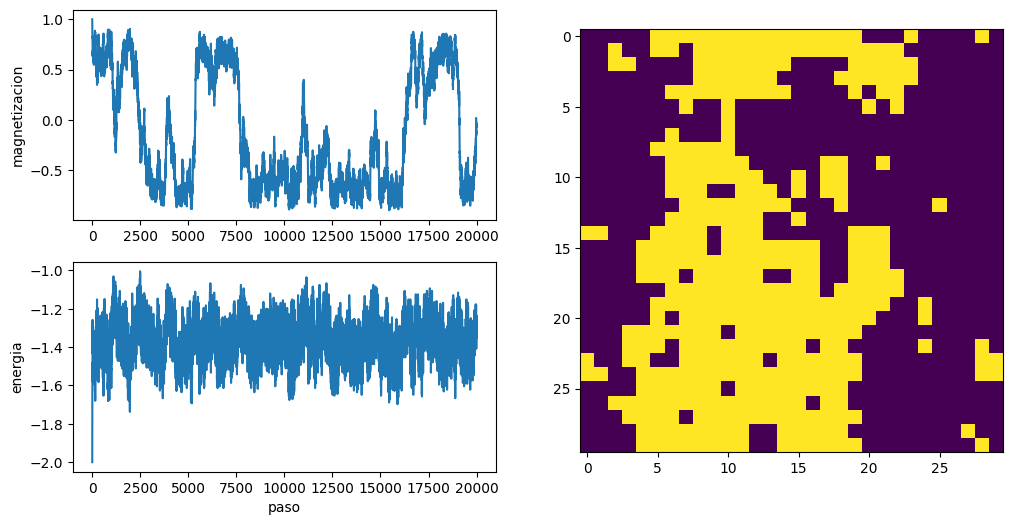

In [ ]:

L=30 #Lado de la red
beta=1/2.3

nequilibrio=20000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
#S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio):
  de,S,dm=metropolis(S,prob)
  m[n]=m[n-1]+dm/L**2
  e[n]=e[n-1]+de/L**2

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)#La
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.show()

# Promedios

En esta sección buscamos identificar alrededor de que valor fluctuan la energía y la magnetización, es decir la energía y magnetización media. Para esto simplemente graficamos en función de los pasos el promedio de las energias obtenidas hasta el momento. Hacemos lo mismo con el modulo de la magnetización. De esta manera nos deshacemos de todo el ruido que surge de las fluctuaciones.  

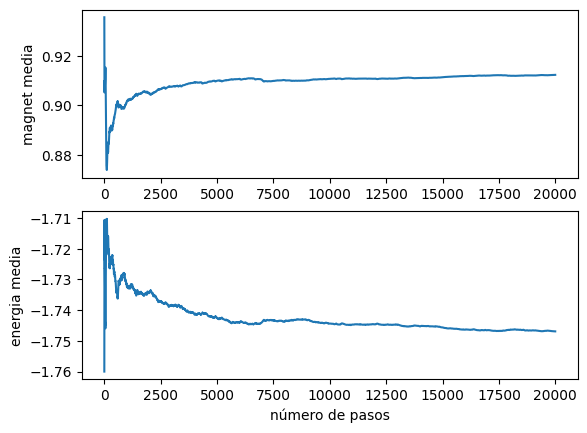

In [ ]:
L=30
beta=1/2

nequilibrio=1000 #Este valor lo decidimos en base a lo anterior
npromedio=20000 #Numero de pasos tentativo para calcular promedios
prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])
S=np.ones((L,L),dtype=int)

for n in range(nequilibrio):
  de,S,dm=metropolis(S,prob) #Termalizamos

m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  de,S,dm=metropolis(S,prob)
  m[n]=m[n-1]+dm/L**2
  e[n]=e[n-1]+de/L**2
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('magnet media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('energia media')
plt.xlabel('número de pasos')
plt.show()

#Transciciones de Fase

Ahora hacemos un barrido de temperaturas calculando y en cada una la energía y magnetización media por partícula. Luego gráficamos. Se puede ver que la energía por partícula media es apenas mayor a $-2$ aunque creciente hasta que se llega a las cercanias de la temperatura crítica, la cual es $\approx2.27$, que empieza a subir rápidamente hasta llegar aproximadamente a $0$ que se vuelve a estabilizar y vuelve a crecer a un ritmo más moderado. Algo similar pasa con la magnetización, que es cercano aunque menor a $1$ hasta llegar a las cercanías de la temperatura crítica que desciende bruscamente hasta casi llegar a $0$. A medida que se aumenta la longitud de la matriz, es decir, el número de partículas, los cambios son cada vez más bruscos, lo que nos lleva a pensar que en el limite termodinámico ($N→ ∞$) serán directamente gráficos escalonados.

En esta sección tambien calculamos y gráficamos el calor específico ($C_v$) y la susceptibilidad ($\chi$) en función de la temperatura. Para esto utilizamos las fórmulas

$$C_v = L^2\cdot \frac{Var(E)}{T²} = L^2\cdot \frac{<E²>-<E>²}{T²} = \left. \frac{\partial E}{\partial T} \right|_{V},$$
$$\chi= L^2\cdot \frac{Var(m)}{T} = L^2\cdot \frac{<m²>-<m>²}{T}.$$

Se puede ver que los gráfico están muy cerca del cero a excepción de las cercanias de la temperatura crítica donde aumentan bruscamente habiendo en $T_c$ un máximo y luego disminuyen de nuevo bruscamente hasta volver a estar nuevamente muy cerca del cero.

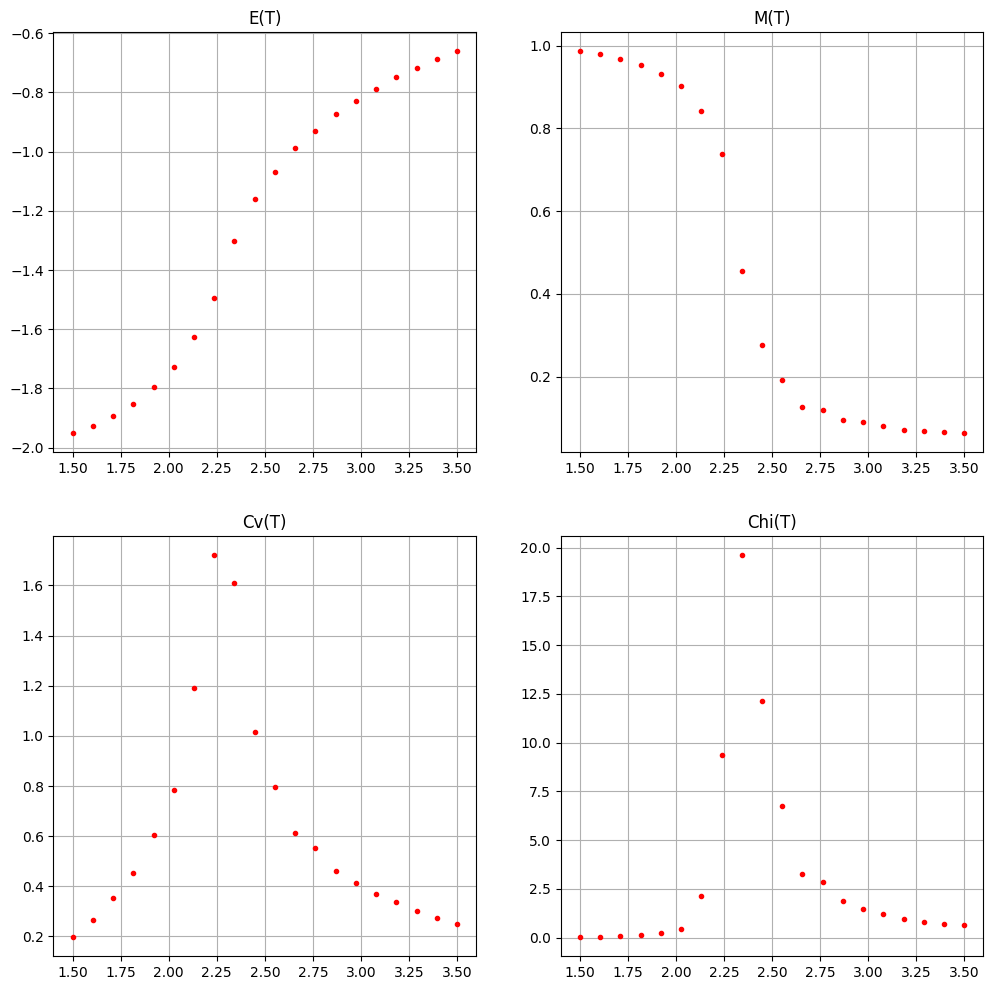

In [ ]:
T = np.linspace(1.5,3.5,20)
valorm = []
valore = []
valorcv=[]
valorsuscep=[]
for i,j in enumerate(T):
  L=32
  beta=1/j

  nequilibrio=1000 #Este valor lo decidimos en base a lo anterior
  npromedio=20000 #Numero de pasos tentativo para calcular promedios
  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  S=np.ones((L,L),dtype=int)

  for n in range(nequilibrio):
    de,S,dm=metropolis(S,prob) #Termalizamos

  m=np.zeros(npromedio)
  e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso

  e2=np.zeros(npromedio)
  m2=np.zeros(npromedio)

  m[0]=np.mean(S)
  e[0]=h(S)

  e2[0]=e[0]**2
  m2[0]=m[0]**2



  mmedia=[abs(m[0])]
  emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

  e2media = [e2[0]]

  m2media = [m2[0]]

  for n in range(1,npromedio):
    de,S,dm=metropolis(S,prob)
    m[n]=m[n-1]+dm/L**2
    e[n]=e[n-1]+de/L**2

    e2[n] = e2[n-1] + (e[n]**2 - e2[n-1]) / (n + 1) #basicamente me devuelve las cosas ya promediadas
    m2[n] = m2[n-1] + (m[n]**2 - m2[n-1]) / (n + 1)
    #e2[n] = e[n]**2
    #m2[n] = m[n]**2

    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))

    e2media.append(e2[n])
    m2media.append(m2[n])


  valorm.append(np.mean(mmedia))
  valore.append(np.mean(emedia))

  Cv = (e2media[-1] - (emedia[-1])**2) / (j**2)
  #Cv = ((np.array(e2media) - np.array(emedia)**2) / (beta**2)) / (L**2)
  valorcv.append(Cv*L**2)
  chi = (m2media[-1] - (mmedia[-1])**2) / (j)
  #suscep = ((np.array(m2media) - np.array(mmedia)**2) / (beta**2)) / (L**2)
  valorsuscep.append(chi*L**2)





fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
plt.grid(True)
ax1.plot(T,valore,'r.')
ax2 = fig.add_subplot(222)
plt.grid(True)
ax2.plot(T,valorm,'r.')
ax3 = fig.add_subplot(223)
plt.grid(True)
ax3.plot(T,valorcv,'r.')
ax4 = fig.add_subplot(224)
plt.grid(True)
ax4.plot(T,valorsuscep,'r.')
ax1.title.set_text('E(T)')
ax2.title.set_text('M(T)')
ax3.title.set_text('Cv(T)')
ax4.title.set_text('Chi(T)')
plt.show()



In [ ]:
import pandas as pd

data1 = np.loadtxt('/content/C_32x32.txt', delimiter=' ')
data2 = np.loadtxt('/content/U_32x32.txt', delimiter=' ')

xE = data2[:,0]
yE = data2[:,1]

xCv = data1[:,0]
yCv = data1[:,1]

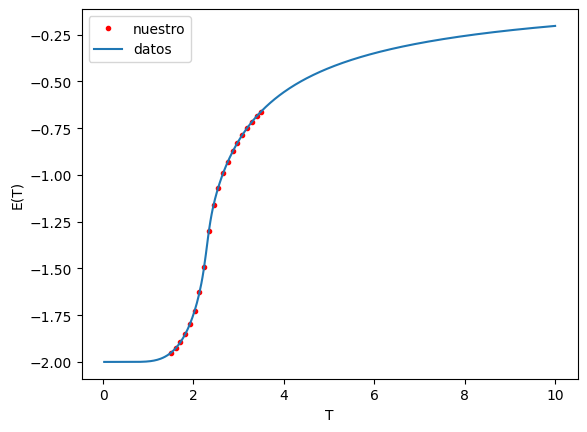

In [ ]:
plt.plot(T,valore,'r.',label = 'nuestro')
plt.plot(xE,-yE,label='datos') #la energia que obtuvimos es la que se encuentra en los datos*(-1)
plt.xlabel('T')
plt.ylabel('E(T)')
plt.legend()
plt.show()

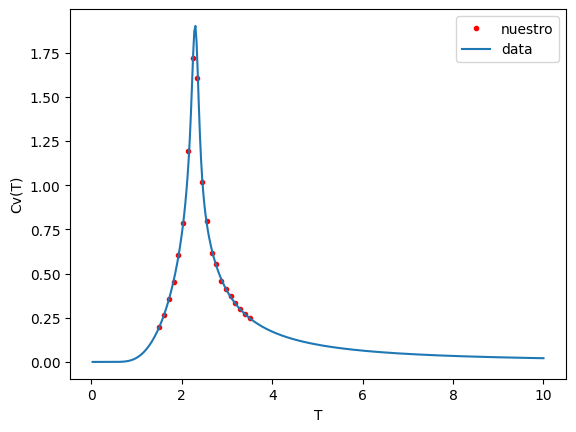

In [ ]:
plt.plot(T,valorcv,'r.',label='nuestro')
plt.plot(xCv,yCv,label='data')
plt.xlabel('T')
plt.ylabel('Cv(T)')
plt.legend()
plt.show()

# Correlaciones

Volvemos a la definición de funciones. En esta sección serán la función de correlación, **`cor`** y de nuevo el algoritmo de Metropolis, esta vez con el nombre de **`metropolis2`**.

La función de correlación se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la longitud de correlación, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica.

La función **`cor(S)`** calcula la correlación de un estado representado por una matriz $S$ de dimensión $L \times L$ y devuelve un vector de correlaciones $c$ con $L/2$ componentes. Aquí hay una explicación del funcionamiento del código:

- Se inicializa un vector $cor$ de ceros con $L/2$ componentes.
- Para cada desplazamiento $r$ desde $0$ hasta $L/2$:
  - Se inicializa $c_r$ a $0$.
  - Se itera sobre todos los elementos de la matriz $S$.
  - Para cada par de elementos $s_{ij}$ y $s_{i,j+r}$ (teniendo en cuenta las condiciones periódicas), se calcula el producto y se acumula en $c_r$.
  - Se almacena el valor promedio de $c_r$ en el vector de correlación $cor$.
- La función devuelve el vector de correlación $cor$.

En resumen, el código calcula la correlación promedio para distintos desplazamientos $r$ en la matriz $S$, utilizando condiciones periódicas para asegurar que los índices no se salgan de los límites de la matriz.


La segunda función, **`metropolis2(S,beta)`**, es muy similar a la ya explicada anteriormente **`metropolis(s, beta)`**. Implementa el algoritmo de Metropolis para actualizar el estado $S$. La función toma la matriz $S$, el parámetro $β$, y devuelve el nuevo estado de $S$, el incremento de la magnetización $dm$ y el incremento del vector de correlación $dc$.

Hecho esto, empleamos las funciones definidas para determinar la función de correlación a varias temperaturas. Ajustamos los resultados obtenidos con una función de la forma $a\cdot e^{-r/ξ}$, lo que nos permite obtener la longitud de correlación ($\xi$) para cada una de esas temperaturas.

Finalmente, hacemos un barrido de temperaturas en un rango que incluya a la temperatura crítica ($T_c$) calculando en cada caso la longitud de correlación y graficamos $xi (T)$.

In [ ]:
@njit
def cor(S):
  L = len(S)
  cor = np.zeros(int(L/2))
  for r in range(0,L/2):
    c_r=0
    for i in range(0,L):
      for j in range(0,L):
        c_r += (1/L**2)*S[i,j]*S[i,(j+r)%L]
    cor[r]=c_r
  return cor

#L=30
#S=2*np.random.randint(2,size=(L,L))-1
#c = cor(S)
#print(c)

In [ ]:
@njit

def metropolis2(S,prob): #Aplica el algoritmo de Metropolis al estado S
  L = len(S)
  dm = 0
  dc = np.zeros(int(L/2))

  for n in range(0,L*L):
    i, j = np.random.randint(0, L), np.random.randint(0, L)

    nuevo_estado = np.copy(S)
    nuevo_estado[i,j] *= -1

    de1 = (-nuevo_estado[i,j]*(nuevo_estado[(i-1)%L,j]+nuevo_estado[(i+1)%L,j]+nuevo_estado[i,(j-1)%L]+nuevo_estado[i,(j+1)%L])) - (-S[i,j]*(S[(i-1)%L,j]+S[i,(j-1)%L]+S[(i+1)%L,j]+S[i,(j+1)%L]))

    a = (nuevo_estado[i,j] - S[i,j])  #esto es el dm, es lo mismo que hacer 2*S[i,j]

    b = np.zeros(int(L/2))

    para_c = np.copy(S[i,:])  #creo vector copia de S para calcular dc
    para_c[j] *=-1

    for r in range(0,L/2):
      dc_r = (1/L**2)*((para_c[j]*para_c[(j+r)%L]+para_c[(j-r)%L]*para_c[j])-(S[i,j]*S[i,(j+r)%L]+S[i,(j-r)%L]*S[i,j]))
      b[r]=dc_r


    if de1 <= 0:
      dm += a
      S[i, j] *= -1  # Dar vuelta al espín
      dc += b
    else:
      if de1==4 and np.random.rand() < prob[0]:
        dm += a
        S[i, j] *= -1  # Dar vuelta al espín
        dc += b
      elif de1==8 and np.random.rand() < prob[1]:
        dm += a
        S[i, j] *= -1  # Dar vuelta al espín
        dc += b
      else:
        dm+=0
        dc+=0
#     for r in range(0,L/2):
#       dc_r = (1/L**2)*((para_c[j]*para_c[(j+r%L)]+para_c[(j-r)%L]*para_c[j])-(S[i,j]*S[i,(j+r)%L]+S[i,(j-r)%L]*S[i,j]))
#       dc[r]=dc_r
        #print(dc_r)


  return dc,S,dm

#L=20
#S=2*np.random.randint(2,size=(L,L))-1
#print(S)

#beta=1/2.3

#dc,S,dm = metropolis2(S,beta)
#print(dc)
#print(dm)
#print(S)



In [ ]:
L=30

nequilibrio=1000
npromedio=50000


l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

for T in [1.5,2.3,3]:

  beta=1/T

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    de,S,dm=metropolis(S,prob)


  m[0]=np.mean(S)
  c[:,0]=cor(S)

  for n in range(1,npromedio):
    dc,S,dm=metropolis2(S,prob)
    m[n]=m[n-1]+dm/(L**2)
    c[:,n]=c[:,n-1]+dc


  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  print('T={} => {}'.format(T,parametros[1]))

  plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='T={}'.format(T))

plt.xlabel('r')
plt.ylabel('funcion de correlacion')
plt.legend()
plt.show()

In [ ]:

nequilibrio=1000
npromedio=50000

l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

T = np.linspace(1.5,3.5,40)

longitud_corr=[]

for i in T:
  beta=1/i
  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    de,S,dm=metropolis(S,prob)


  m[0]=np.mean(S)
  c[:,0]=cor(S)

  for n in range(1,npromedio):
    dc,S,dm=metropolis2(S,prob)
    m[n]=m[n-1]+dm/(L**2)
    c[:,n]=c[:,n-1]+dc


  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  print('T={} => {}'.format(i,parametros[1]))

  #plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='i={}'.format(i))

  longitud_corr.append(parametros[1])

#plt.xlabel('r')
#plt.ylabel('funcion de correlacion')
#plt.legend()
#plt.show()


plt.plot(T,longitud_corr,'.')

#Temperatura Crítica

En esta parte de la práctica buscamos la temperatura crítica para la red infinita. Para ello usamos el modelo lineal propuesto:

$$T_c(x)=Ax+T_c(\infty),\, x=1/L$$

Para las redes de 15, 30, 60 y 120 de lado, hacemos un zoom en el pico de la suceptibilidad y ajustamos los puntos por una cuadrática. De dicho ajuste se obtiene Tc(x) para un x fijo. Por último, realizamos el ajuste lineal sobre las coordenadas (x,Tc) obtenidas y el parámetro constante nos da la temperatura crítica de la red infinita. En nuestro caso obtuvimos $T\approx 2.270$.

Para las redes de L=15 y L=30, los valores medios de la magnetización los obtuvimos con 50.000 pasos (npromedio) del algoritmo Metropolis. En el caso de L=60 con 100.000 pasos. Por último, para L=120, promediamos con 400.000 pasos.

In [ ]:
#Acá redefinimos las funciones previas porque mezclamos códigos para distintos items y no pudimos hacer funcionar este item
#con las funciones ya defiinids si bien les cambiamos las diferencias para que funcionaran.

@njit
def random_ij(N):
    l=np.arange(0,N,1)
    i=np.random.choice(l)
    j=np.random.choice(l)
    return i,j

@njit
def Eij(S, i, j):
    N = np.shape(S)[0]
    eij = S[i, j]*(S[(i-1)%N,j] + S[i,(j-1)%N] + S[(i+1)%N,j] + S[i,(j+1)%N])
    return eij

@njit
def energy(S):
    e=0
    N=np.shape(S)[0]
    for i in range(N):
        for j in range(N):
            e=e+Eij(S,i,j)
    return -e/2
@njit
def mag(S): return np.sum(S)

#def mag2(S): return np.abs(np.mean(S))
@njit
def denergy(S,i,j): return 2*Eij(S, i, j)
@njit
def dmag(S,i,j): return -2*S[i,j]

@njit
def metropolis(S,T):
    L=np.shape(S)[0]
    b=1/T
    dE=0
    dM=0
    for m in range(L**2):
      i,j=random_ij(L)
      de=denergy(S, i, j)
      dm=dmag(S, i, j)
      p=np.exp(-b*de)
      if de<=0 or np.random.random()<p:
          S[i,j]=-1*S[i,j]
          dE=dE+de
          dM=dM+dm
    return S,dE,dM

##Ajustes cuadráticos para las distintas redes

El modelo propuesto para estos ajustes es:
$$\chi(T)=-A(T-T_c)^2+B$$

###L=15

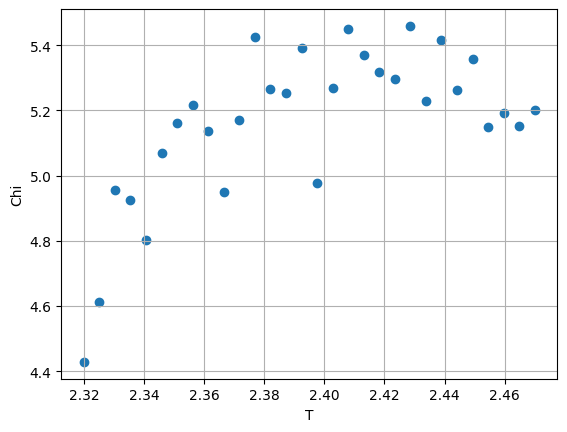

In [ ]:
L=15 #tamaño de la red
T=np.linspace(2.32,2.47,30) #rango de temperaturas a barrer
S=np.ones((L,L),dtype=int) #red de espines
for i in range(L):
     for j in range(L):
         S[i,j]=np.random.choice([-1,1])

neq=5000 #pasos de la termalización
nprom=50000 #pasos para el calculo de valores medios

@njit
def Tcrit(L,S,T,neq,nprom): #el cálculo lo metemos en una función para que numba lo pueda optimizar
  varM=[]

  for t in T:

    for n in range(neq):
      S,_,dm=metropolis(S,t) #Termalizamos

    m=np.zeros(nprom)
    m2=np.zeros(nprom)

    m[0]=mag(S)/L**2
    m2[0]=m[0]**2


    for n in range(1,nprom): #llegamos hasta valores de pasos que hagan converger los valores medios de la magnetización
        S,_,dm=metropolis(S,t)
        m[n]=m[n-1]+dm/L**2
        m2[n]=m[n]**2

    varM.append(L**2*(np.mean(m2)-np.mean(np.abs(m))**2)/t) #calculamos chi con la fórmula citada en secciones anteriores

  return varM

varM=Tcrit(L,S,T,neq,nprom)

plt.figure()
plt.scatter(T,varM)
plt.ylabel('Chi')
plt.xlabel('T')
plt.grid()
plt.show()

[ 2.41639457 77.83569327  5.35368262]
[4.89533334e-03 1.30138805e+01 3.27331915e-02]


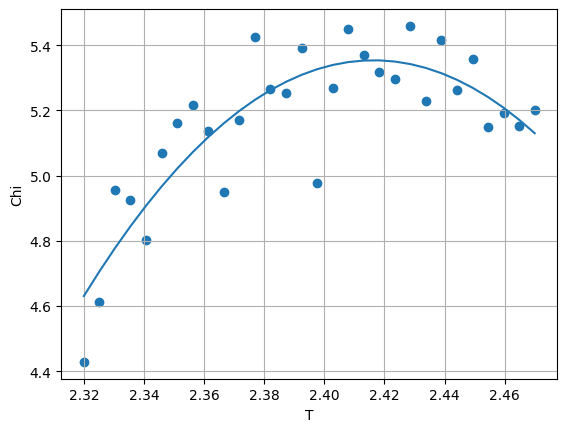

In [ ]:
from scipy.optimize import curve_fit

def cuad(T,Tc,A,B): #definimos modelo cuadrático
  return -A*(T-Tc)**2+B

param,cov=curve_fit(cuad,T,varM,p0=[2.3,100,5]) #damos p0 similar a lo que observamos del gráfico de puntos
print(param)
print(np.sqrt(np.diag(cov)))

plt.figure()
plt.scatter(T,varM)
plt.plot(T,cuad(T,*param))
plt.ylabel('Chi')
plt.xlabel('T')
plt.grid()
plt.show()

###L=30

[   2.34058866 1182.67179571   18.35198174]
[7.69121411e-03 3.08454228e+02 3.98382404e-01]


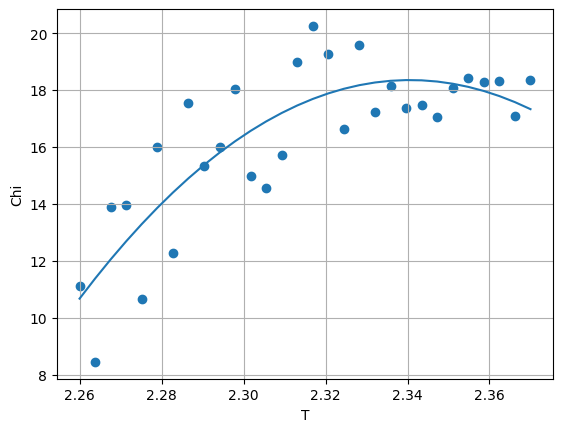

In [ ]:
L=30 #tamaño de la red
T=np.linspace(2.26,2.39,30) #rango de temperaturas a barrer
S=np.ones((L,L),dtype=int) #red de espines
for i in range(L):
     for j in range(L):
         S[i,j]=np.random.choice([-1,1])

neq=5000 #pasos de la termalización
nprom=50000 #pasos para el calculo de valores medios

@njit
def Tcrit(L,S,T,neq,nprom): #el cálculo lo metemos en una función para que numba lo pueda optimizar
  varM=[]

  for t in T:

    for n in range(neq):
      S,_,dm=metropolis(S,t) #Termalizamos

    m=np.zeros(nprom)
    m2=np.zeros(nprom)

    m[0]=mag(S)/L**2
    m2[0]=m[0]**2


    for n in range(1,nprom): #llegamos hasta valores de pasos que hagan converger los valores medios de la magnetización
        S,_,dm=metropolis(S,t)
        m[n]=m[n-1]+dm/L**2
        m2[n]=m[n]**2

    varM.append(L**2*(np.mean(m2)-np.mean(np.abs(m))**2)/t) #calculamos chi con la fórmula citada en secciones anteriores

  return varM

varM=Tcrit(L,S,T,neq,nprom)

from scipy.optimize import curve_fit

def cuad(T,Tc,A,B): #definimos modelo cuadrático
  return -A*(T-Tc)**2+B

param,cov=curve_fit(cuad,T,varM,p0=[2.3,100,5]) #damos p0 similar a lo que observamos del gráfico de puntos
print(param)
print(np.sqrt(np.diag(cov)))

plt.figure()
plt.scatter(T,varM)
plt.plot(T,cuad(T,*param))
plt.ylabel('Chi')
plt.xlabel('T')
plt.grid()
plt.show()

###L=60

[2.30684814e+00 1.16472292e+04 6.01598580e+01]
[2.54511280e-03 1.97859504e+03 2.32280398e+00]


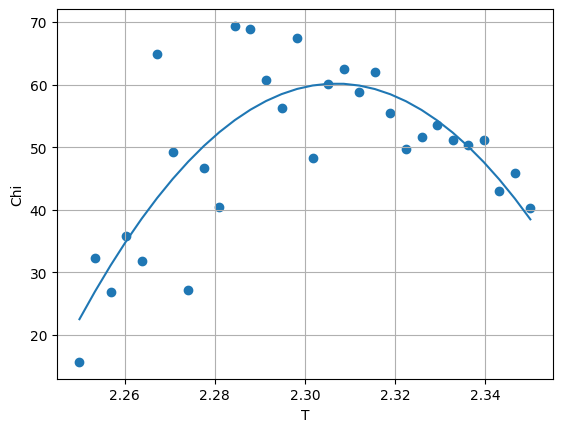

In [ ]:
L=60 #tamaño de la red
T=np.linspace(2.25,2.35,30) #rango de temperaturas a barrer
S=np.ones((L,L),dtype=int) #red de espines

neq=5000 #pasos de la termalización
nprom=100000 #pasos para el calculo de valores medios

@njit
def Tcrit(L,S,T,neq,nprom): #el cálculo lo metemos en una función para que numba lo pueda optimizar
  varM=[]

  for t in T:

    for n in range(neq):
      S,_,dm=metropolis(S,t) #Termalizamos

    m=np.zeros(nprom)
    m2=np.zeros(nprom)

    m[0]=mag(S)/L**2
    m2[0]=m[0]**2


    for n in range(1,nprom): #llegamos hasta valores de pasos que hagan converger los valores medios de la magnetización
        S,_,dm=metropolis(S,t)
        m[n]=m[n-1]+dm/L**2
        m2[n]=m[n]**2

    varM.append(L**2*(np.mean(m2)-np.mean(np.abs(m))**2)/t) #calculamos chi con la fórmula citada en secciones anteriores

  return varM

varM=Tcrit(L,S,T,neq,nprom)

from scipy.optimize import curve_fit

def cuad(T,Tc,A,B): #definimos modelo cuadrático
  return -A*(T-Tc)**2+B

param,cov=curve_fit(cuad,T,varM,p0=[2.3,100,5]) #damos p0 similar a lo que observamos del gráfico de puntos
print(param)
print(np.sqrt(np.diag(cov)))

plt.figure()
plt.scatter(T,varM)
plt.plot(T,cuad(T,*param))
plt.ylabel('Chi')
plt.xlabel('T')
plt.grid()
plt.show()

###L=120

Para esta red cambiamos un poquito el código: creamos una copia de seguridad en Drive de la lista con los valores de Chi(T) y la última iteración de la matriz S. Así cuando perdíamos conexión al servidor, podíamos retomar desde la última temperatura en que quedamos.

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

def save_data(data, filename):
    if isinstance(data, list):
        # Convertir lista a numpy array antes de guardar
        np.save(filename, np.array(data))
    elif isinstance(data, np.ndarray):
        # Guardar directamente si ya es un numpy array
        np.save(filename, data)
    else:
        raise ValueError("El tipo de dato no es soportado. Usa lista o np.ndarray.")

# Función para cargar datos
def load_data(filename):
    try:
        data = np.load(filename, allow_pickle=True)
        # Convertir de vuelta a lista si es necesario
        if data.ndim == 1 and data.dtype == 'O':
            return data.tolist()
        else:
            return data
    except FileNotFoundError:
        print(f"No se encontró el archivo {filename}. Retornando None.")
        return None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
L=120
S=np.ones((L,L),dtype=int)
T=np.linspace(2.27,2.31,20)
neq=10000
nprom=400000

#varM2=np.array([])
varM2=load_data('/content/drive/MyDrive/Colab Notebooks/varM.npy') #recuperamos lista de la ejecución anterior
Slast=load_data('/content/drive/MyDrive/Colab Notebooks/Slast.npy') #recuperamos última matriz de la ejecución anterior
S=np.copy(Slast)

for t in range(20):

  for n in range(neq):
    S,_,dm=metropolis(S,T[t]) #Termalizamos

  m=np.zeros(nprom)
  m2=np.zeros(nprom)

  m[0]=mag(S)/L**2
  m2[0]=m[0]**2

  for n in range(1,nprom): #repetimos metropolis hasta que converja el valor de la magnetización media
    S,_,dm=metropolis(S,T[t])
    m[n]=m[n-1]+dm/L**2
    m2[n]=m[n]**2

  varM2=np.append(varM2,(L**2*(np.mean(m2)-np.mean(np.abs(m))**2)/T[t]))
  Slast=np.copy(S)

  save_data(varM2,'/content/drive/MyDrive/Colab Notebooks/varM.npy') #actualizamos lista Chi(T) en Drive
  save_data(Slast,'/content/drive/MyDrive/Colab Notebooks/Slast.npy') #actualizamos matriz S en Drive



[2.28840330e+00 1.40105104e+05 1.96587835e+02]
[8.20893624e-04 2.03946763e+04 4.00246133e+00]


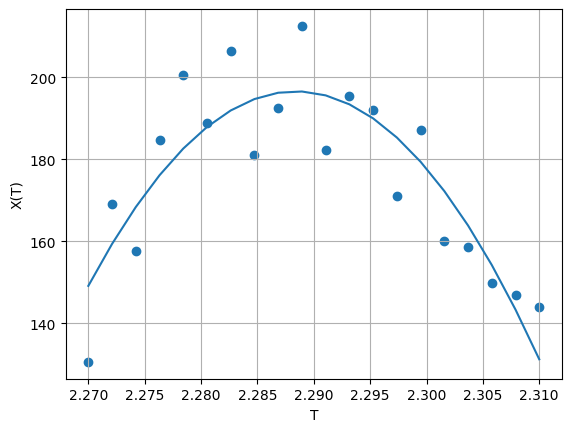

In [ ]:
#acá dejamos la lista de Chi(T) obtenida
varM2=np.array([135.58984223, 169.05322501, 157.58674362, 184.7725441,  200.55323209,
 188.84207151, 206.41088993, 181.15258467, 192.54092984, 212.54092984,
 182.3724512,  195.49575282, 192.14004443, 171.07733756, 187.24527847,
 160.00497343, 158.60088267, 149.72565718, 146.87347502, 144.09267325])

from scipy.optimize import curve_fit

def cuad(T,Tc,A,B): #definimos modelo cuadrático
  return -A*(T-Tc)**2+B

param,cov=curve_fit(cuad,T,varM2,p0=[2.28,1000,200]) #elegimos p0 a partir del gráfico de puntos
print(param)
print(np.sqrt(np.diag(cov)))

plt.figure()
plt.scatter(T,varM2)
plt.plot(T,cuad(T,*param))
plt.ylabel('X(T)')
plt.xlabel('T')
plt.grid()
plt.show()

##Ajuste Lineal

Acá, de manera poco estética, fuimos guardando los valores del ajuste que obteníamos para cada red.

L=15, (T,A,B)=[ 2.41547279 85.695967    5.36029415], error=[4.98263983e-03 1.49234167e+01 3.77113348e-02]

L=30, (T,A,B)=[ 2.34005855 613.04109303  17.56578201], error= [4.23967054e-03 1.32175029e+02 3.96653803e-01]

L=60, (T,A,B)=[2.30684814e+00 1.16472292e+04 6.01598580e+01], error= [2.54511280e-03 1.97859504e+03 2.32280398e+00]

L=120, (T,A,B)=[2.28840330e+00 1.40105104e+05 1.96587835e+02], error=[8.20893624e-04 2.03946763e+04 4.00246133e+00]

2.2883946220866664
Temperatura crítica:  2.270400664295871  +/-  0.0005036926126538033


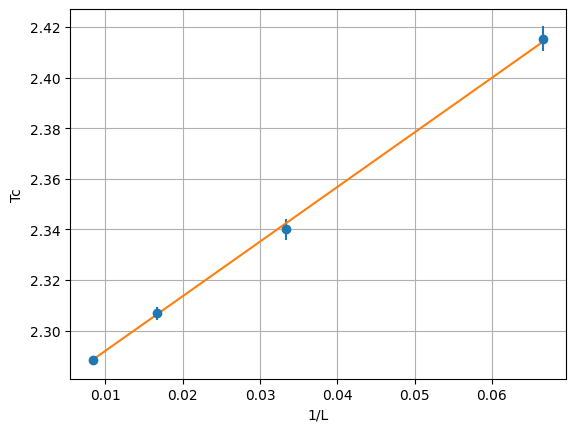

In [ ]:
L=np.array([15,30,60,120])
x=1/L
T=np.array([2.41547279,2.34005855,2.30684814,2.28840330]) #pegamos los resultados obtenidos de los ajustes cuadráticos
error=np.array([4.98263983e-03,4.23967054e-03,2.54511280e-03,8.20893624e-04])
def lineal(x,A,B): #modelo típico de lineal
  return A*x+B

param,cov=curve_fit(lineal,x,T,sigma=error,method='lm')
Tc=param[1]
errc=np.sqrt(cov[1,1])
print('Temperatura crítica: ',Tc,' +/- ',errc)

plt.figure()
plt.errorbar(x,T,yerr=error,fmt='o')
plt.plot(x,lineal(x,*param))
plt.xlabel('1/L')
plt.ylabel('Tc')
plt.grid()
plt.show()